# Machine Learning Pipeline - Production

Check the python kernel we are using, should be the local one, not the one in the virtual environment. <br> 
NOTE: A proper virtual environment will be setup later on

In [41]:
import sys
print(sys.executable)

/usr/bin/python3


## Define Variables

Set up main variables that will be called later on, for readibility purposes

In [42]:
install_bool = False
path_to_datasets = "/home/ieo7429/Desktop/THESIS_GAB/outfiles/target_variables/ML_tables_regression_classification_BRCA_v2.RData"
mode = "regrout"

target_variable = "mean_log2FC"

cols_to_drop = ["joint_probability", "bool_diff_acc", 
                "sign_mean_log2FC_1", "sign_mean_log2FC_2", "sign_mean_log2FC_3", 
                "weighted_coef_of_var_log2FC", "weighted_log2FC", "bin", "Type"]

cols_to_check = ["mean_log2FC", "weighted_log2FC", "weighted_coef_of_var_log2FC",
                 "joint_probability", "bool_diff_acc", "sign_mean_log2FC_1", 
                 "sign_mean_log2FC_2", "sign_mean_log2FC_3", "joined_direction"]

if "ampl_score" in cols_to_drop and "del_score" in cols_to_drop:
    condition = "without_CNA"
else:
    condition = "with CNA"

n_jobs = 60
nthread = 60
n_iter_bsearch = 150
n_iter_rsearch = 300

split_random_state = 489574
regressor_seed = 3737
regressor_random_state = 39473209
hypertune_random_state_bsearch = 3847
hypertune_random_state_rsearch = 49574
kfold_random_state = 4909

outer_cv = 5
inner_cv = 3
plot_variation = True
plot_shap = True

X_train_filename = "Regression_Output/regression_X_train_red"; X_test_filename = "Regression_Output/regression_X_test_red"
y_train_filename = "Regression_Output/regression_y_train_red"; y_test_filename = "Regression_Output/regression_y_test_red"
bin_train_filename = "Regression_Output/regression_bin_train_red"; bin_test_filename = "Regression_Output/regression_bin_test_red"
model_filename = "Regression_Output/regressor_final_model"

## Install packages

Install all needed packages

In [43]:
from IPython.display import clear_output

if install_bool:
    ! pip install pickleshare
    ! pip install pandas
    ! pip install scikit-learn
    ! pip install seaborn
    ! pip install scipy
    ! pip install --upgrade pip setuptools wheel
    ! pip install rpy2
    ! pip install shap
    ! pip install "numpy<=2.1"
    %pip install -U ipywidgets

clear_output(wait = False)

## Import libraries

Import all packages

In [44]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import rpy2.robjects as ro
import xgboost as xgb
import shap
import warnings
import random
import pickleshare
import pickle
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectFromModel

## Define Functions

### load_datasets_from_r
Reads "ML.Tables" .Rdata file and converts it to a nested dictionary.

In [45]:
def load_datasets_from_r(file_path):

    """ 
    The function uses rpy2 to load datasets from an RData file.
    In particular it expects a list of data.frames
    It returns a dictionary of pandas DataFrames.
    """
    
    pandas2ri.activate()

    ro.r['load'](file_path) # load the .RData

    env = ro.globalenv # set the environment

    r_list = env[list(env.keys())[0]] # take the list object

    list_names = ro.r['names'](r_list) # take the names
    list_names = [str(name) for name in list_names]

    df_dict = {} # initialize outer dictionary
    with (ro.default_converter + ro.pandas2ri.converter).context(): # start the conversion
    # the conversion transforms a list of lists of lists of data.frames 
    # to a list of dictionaries of dictionaries of dictionaries of DataFrame
        i = 0
        for outer_dict in r_list:
            df_dict[list_names[i]] = outer_dict
            i += 1
            
    return(df_dict)

### plot_observed_predicted
This function plots observed values and predicted values to give a quick visual inspection

In [46]:
def plot_observed_predicted(list_of_arrays, list_of_labels, title, x_label, y_label):

    """
    The function takes a list of values and a list of labels as input and plots them.
    NOTE: No genomic spatial relationship is preserved in the plot.
    """
    n = len(list_of_arrays)

    colors = sns.color_palette("dark", n_colors = n)

    for i in range(n):
        color = colors[i]
        sns.lineplot(list_of_arrays[i], color = color, label = list_of_labels[i])
        sns.scatterplot(list_of_arrays[i], color = color)
    plt.title(title, fontsize = 30)
    plt.xlabel(x_label, fontsize = 16)
    plt.ylabel(y_label, fontsize = 16)
    plt.legend(fontsize = 16)
    plt.xticks([])

### adjusted R^2

This function allows the computation of adjusted R^2, passing it as a custom scikit-scorer

In [47]:
def adj_r2_score(y_true, y_pred, **kwargs):
    n, p = X.shape
    r2 = sk.metrics.r2_score(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    return adjusted_r2

In [48]:
adjusted_r2 = sk.metrics.make_scorer(adj_r2_score, response_method = "predict", greater_is_better= True)

### feature_selector
This function performs Incremental Feature Selection (IFS) to produce a reduced model <br> with best R2 performance with cross validation.
Mean absolute SHAP values are used to select features

In [49]:
def feature_selector_shap(feature_names, feature_importances, model, 
                          X_train, X_test, y_train, inner_cv,
                          plot = True, verbose = True):

    """
    The function takes as input feature names, feature importances, 
    a XGBoostRegressor object, the training and test dataset
    and returns the reduced training and test datasets.
    - plot parameter regulates whether or not to plot the R2 vs number of feature plot
    - verbose parameter regulates whether or not to produce a text output
    """


    thresholds = np.sort(feature_importances) # sort the feature importances
    num_features_list = [] # initialize list
    r2_scores_list = [] # initialize list
    
    for threshold in thresholds: # iterate over thresholds
        
        vars_to_keep = np.where(feature_importances >= threshold)[0]
        X_train_selected = X_train.iloc[:,vars_to_keep]

        r2_scores = sk.model_selection.cross_val_score(estimator = model, 
                                                       X = X_train_selected, y = y_train, 
                                                       scoring = adjusted_r2, cv = inner_cv)
        mean_r2_score = np.mean(r2_scores)
        
        num_features_list.append(X_train_selected.shape[1]) # append
        r2_scores_list.append(mean_r2_score) # append

        if verbose:
            print(f'> threshold={threshold}, features={X_train_selected.shape[1]}, adj_R2={mean_r2_score}')
        
        if len(vars_to_keep) == 1:
            break

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(num_features_list, r2_scores_list, marker='o')
        plt.xlabel('Number of Selected Features')
        plt.ylabel('cross validated mean R2')
        plt.title('R2 vs. Number of Selected Features')
        plt.grid(True)
        plt.show()

    optimal_threshold_index = np.argmax(r2_scores_list)
    optimal_num_features = num_features_list[optimal_threshold_index]
    
    if (optimal_threshold_index) == 0:
        optimal_threshold = 0
    else:   
        optimal_threshold = thresholds[optimal_threshold_index - 1]

    if verbose:
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Number of Selected Features: {optimal_num_features}")
        print(f"R2 at Optimal Threshold: {r2_scores_list[optimal_threshold_index]:.4f}")
        print("\n")
        
    n = 5
    selected_features = feature_names[np.where(feature_importances > optimal_threshold)]
    selected_features = [str(name) for name in selected_features]
    discarded_features = [str(name) for name in feature_names if str(name) not in selected_features]

    if verbose:
        print("Selected features are: \n")
        for i in range(0,len(selected_features), n):
            print("  ".join(selected_features[i:i+n]))
        print("\n")
        print("Discarded features are: \n")
        for i in range(0,len(discarded_features), n):
            print("  ".join(discarded_features[i:i+n]))

    X_train_reduced = X_train[selected_features]
    X_test_reduced = X_test[selected_features]
    
    return(X_train_reduced, X_test_reduced, selected_features)    

### nested CV

This function performs nested cross validation, optimizing the model at each step in order to properly estimate the model's error

In [50]:
def nested_CV(outer_cv, inner_cv,
              X_train, y_train, 
              model, search_space, 
              n_jobs, n_iter_bsearch, verbose):
    
    """
    The function performs nested cross validation to estimate model's error rate
    It take the cv number, the training dataset, the target variable, the model or a BayesSearchCV
    and a search space to perform hyperparameter tuning
    """

    kf = sk.model_selection.KFold(n_splits = outer_cv, 
                                  shuffle = True, 
                                  random_state = kfold_random_state)
    
    mse_array = np.zeros(outer_cv)
    r2_array = np.zeros(outer_cv)
    predictions_array = np.zeros(len(X_train))
    
    i = 0
    for train_index, val_index in kf.split(X_train):

        if verbose:
            print(f"Fold #{i + 1}")
        
        if verbose:
            print("STEP 1 (Splitting)")
            
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        if verbose:
            print("STEP 2 (Tuning)")
            
        opti = BayesSearchCV(
            estimator = model,
            search_spaces = search_space,
            n_iter = n_iter_bsearch,
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True,
            n_jobs = n_jobs,
            verbose = False
        )
        
        opti.fit(X_train_cv, y_train_cv)
        best_model = opti.best_estimator_
    
        if verbose:
            print("STEP 3 (Prediction)")
            
        cv_predictions = best_model.predict(X_val)
        cv_mse = sk.metrics.mean_squared_error(y_val, cv_predictions)
        cv_r2 = sk.metrics.r2_score(y_val, cv_predictions)
        
        mse_array[i] = cv_mse
        r2_array[i] = cv_r2
        predictions_array[val_index] = cv_predictions
        
        i += 1

    return(mse_array, r2_array, predictions_array)

### nested CV la vendetta

In [51]:
def nested_CV_revenge(outer_cv, inner_cv, 
                      X_train, y_train, 
                      model, search_space, 
                      n_jobs, n_iter_bsearch, verbose):
    
    """
    The function performs nested cross validation to estimate model's error rate
    It take the cv number, the training dataset, the target variable, the model or a BayesSearchCV
    and a search space to perform hyperparameter tuning
    """

    kf = sk.model_selection.KFold(n_splits = outer_cv, 
                                  shuffle = True, 
                                  random_state = kfold_random_state)

    hyperparam_list = []
    selected_features_list = []
    mse_array = np.zeros(outer_cv)
    r2_array = np.zeros(outer_cv)
    predictions_array = np.zeros(len(X_train))
    
    i = 0
    for train_index, val_index in kf.split(X_train):

        if verbose:
            print(f"Fold #{i + 1}")
            
        if verbose:
            print("STEP 1 (Splitting)")
            
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        if verbose:
            print("STEP 2 (Tuning)")

        if verbose:
            print("STEP 2.1 (HyperParameter Tuning Part 1)")
        
        opti = BayesSearchCV(
            estimator = model,
            search_spaces = search_space,
            n_iter = n_iter_bsearch,
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True,
            n_jobs = n_jobs,
            verbose = 0
        )
        
        opti.fit(X_train_cv, y_train_cv)
        best_model = opti.best_estimator_

        if verbose:
            print("STEP 2.2 (SHAP)")
        
        explainer = shap.TreeExplainer(best_model)

        feature_names = best_model.feature_names_in_
        feature_importances_shap = np.mean(np.abs(explainer.shap_values(X_train_cv)), axis = 0)
    
        if verbose:
            print("STEP 2.3 (Feature selection)")
        
        X_train_cv_reduced, X_val_cv_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                                        best_model, 
                                                                                        X_train_cv, X_val, y_train_cv, 
                                                                                        inner_cv,
                                                                                        plot = False, verbose = False)

        if verbose:
            print("STEP 2.4 (HyperParameter Tuning Part 2)")
        
        opti_fs = BayesSearchCV(
            estimator = best_model, 
            search_spaces = search_space, 
            n_iter = n_iter_bsearch, 
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True, 
            n_jobs = n_jobs,
            verbose = 0
        )
            
        opti_fs.fit(X_train_cv_reduced, y_train_cv)
        best_model_fs = opti_fs.best_estimator_
        best_params_fs = opti_fs.best_params_
        
        if verbose:
            print("STEP 3 (Prediction)")
            
        cv_predictions = best_model_fs.predict(X_val_cv_reduced)
        cv_mse = sk.metrics.mean_squared_error(y_val, cv_predictions)
        cv_r2 = sk.metrics.r2_score(y_val, cv_predictions)

        hyperparam_list.append(best_params_fs)
        selected_features_list.append(selected_features)
        mse_array[i] = cv_mse
        r2_array[i] = cv_r2
        predictions_array[val_index] = cv_predictions
       
        i += 1

    return(hyperparam_list, selected_features_list, 
           mse_array, r2_array, predictions_array)

## Load Data

Call the load_datasets_from_r function to load all data

In [52]:
output_dict = load_datasets_from_r(path_to_datasets)

In [53]:
working_df = output_dict[mode]

## Prepare Data

In [54]:
bin_ids = working_df[["bin"]]
working_df = working_df.drop(cols_to_drop, axis= 1)

In [55]:
X = working_df.loc[:, working_df.columns != target_variable]
y = working_df.loc[:, target_variable]

In [56]:
if len([col for col in cols_to_check if col in X.columns]) > 0:
    raise Exception("Target Variable and derivated in the training set!")
else:
    print("Target Variable outside training set!")

Target Variable outside training set!


In [57]:
X.head()

,ampl_score,del_score,mean.GC.content,total_n_partners.trans,total_n_PPIs.trans_IntINSIDER,total_n_ohnologs.mmpaper_trans,total_n_paralogs_trans,dist.to.closest.FGS,Length_Counts.E1,Length_Counts.E10,...,distance.to.centromere,distance.to.telomere,Ess.distance_pancancer,ESSscore_pancancer,HAPLOscore_pancancer,Density.complex.proteins,Density.Ohnologs,Chromosome_Length,Centromere_Length,Centromere_Type
1,0.044986,0.320525,50.325833,2.0,52.0,10.0,35.0,61789940.0,5400.0,22800.0,...,114289940.0,6791450.0,1.0,0.000000,0.416667,0.083333,0.500000,249250621,2906265,0
2,0.075914,0.243674,36.060000,0.0,12.0,1.0,2.0,26299595.0,1000.0,1400.0,...,24199400.0,96881990.0,1.0,0.000000,0.000000,0.000000,1.000000,249250621,2906265,0
3,0.074977,0.241799,38.824545,4.0,54.0,2.0,8.0,27300601.0,3600.0,3500.0,...,23198394.0,97882996.0,0.0,0.090909,0.090909,0.090909,0.181818,249250621,2906265,0
4,0.076851,0.248360,39.422000,12.0,650.0,7.0,12.0,28301607.0,1900.0,0.0,...,22197388.0,98884002.0,1.0,0.000000,0.400000,0.400000,0.200000,249250621,2906265,0
5,0.074039,0.234302,35.120000,0.0,6.0,6.0,4.0,29302613.0,0.0,0.0,...,21196382.0,99885008.0,1.0,0.000000,0.000000,0.000000,1.000000,249250621,2906265,0


Split train and test: 
- In this case we do 70% training that will be processed by BayesSearchCV with cv = 5
- The remaining 30% will be used for testing

In [58]:
X_train, X_test, y_train, y_test, bin_train, bin_test = sk.model_selection.train_test_split(X, y, bin_ids, 
                                                                                            test_size = 0.3, 
                                                                                            random_state = split_random_state)

## Prepare the Regressors and the Search Space

Remember to set the seed and random_state parameters in order to ensure reproducibility <br>
NOTA: As it appears from the documentation, seed parameter is now deprecated, so set both seed and random_state to be sure

Set up also the search_space for BayesSearchCV: They are large intervals, but BayesSearchCV is more efficient than regular GridSearchCV

In [59]:
regressor = xgb.XGBRegressor(n_jobs = n_jobs, 
                             nthread = nthread, 
                             seed = regressor_seed, 
                             random_state = regressor_random_state)

search_space_bayes = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'min_child_weight': (0, 10),
    'max_depth': (0, 50),
    'max_delta_step': (0, 20),
    'subsample': (0.01, 1.0, 'uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'colsample_bylevel': (0.01, 1.0, 'uniform'),
    'reg_lambda': (1e-9, 1000, 'log-uniform'),
    'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    'gamma': (1e-9, 0.5, 'log-uniform'),
    'n_estimators': (50, 100),
    'scale_pos_weight': (1e-6, 500, 'log-uniform')
}

### NESTED CV PIPELINE

In [60]:
results = nested_CV_revenge(outer_cv = outer_cv,
            inner_cv = inner_cv,
            X_train = X_train, 
            y_train = y_train, 
            model = regressor, 
            search_space = search_space_bayes,
            n_jobs= n_jobs, n_iter_bsearch = n_iter_bsearch,
            verbose = True
           )

(
    hyperparam_list, 
    selected_features_list, 
    mse_array, 
    r2_array, 
    predictions_array 
) = results

Fold #1
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)


STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Prediction)
Fold #2
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Prediction)
Fold #3
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Prediction)
Fold #4
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Prediction)
Fold #5
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Prediction)


In [61]:
print(f"The cross-validated root mean squared error (cv = {outer_cv}) is : {np.mean(np.sqrt(mse_array))}")
print(f"The cross-validated R squared (R^2) (cv = {outer_cv}) is : {np.mean(r2_array)}")

The cross-validated root mean squared error (cv = 5) is : 0.23768270848217643
The cross-validated R squared (R^2) (cv = 5) is : 0.4446228948674225


In [62]:
selected_features_in_at_least_one_cv = set([elem for inner_list in selected_features_list for elem in inner_list])

In [63]:
search_space_grid = {}

for dictionary in hyperparam_list:
    for k,v in dictionary.items():
        if k in search_space_grid:
            search_space_grid[k].update([v])
        else:
            search_space_grid[k] = set([v])

search_space_grid = {k : list(v) for k,v in search_space_grid.items()}

## Full Dataset Hyperparameter Tuning

Once the true model error has beem estimated we can optimize the hyperparameter on the full training set

In [64]:
opti = sk.model_selection.RandomizedSearchCV(estimator = regressor, 
                                             param_distributions = search_space_grid, 
                                             cv = inner_cv, 
                                             n_jobs = n_jobs,
                                             n_iter = n_iter_rsearch,
                                             random_state = hypertune_random_state_rsearch, 
                                             verbose = 0, refit = True)
opti.fit(X_train, y_train)
clear_output(wait = False)

In [65]:
model = opti.best_estimator_

## Feature Importance Analysis

Let's look at both XGBoost native feature importance and at mean absolute SHAP values as metric of feature importance

In [66]:
explainer = shap.TreeExplainer(model, approximate= False)
shap_values = explainer(X_train)
shap_values_numpy = explainer.shap_values(X_train)

regrout / with CNA


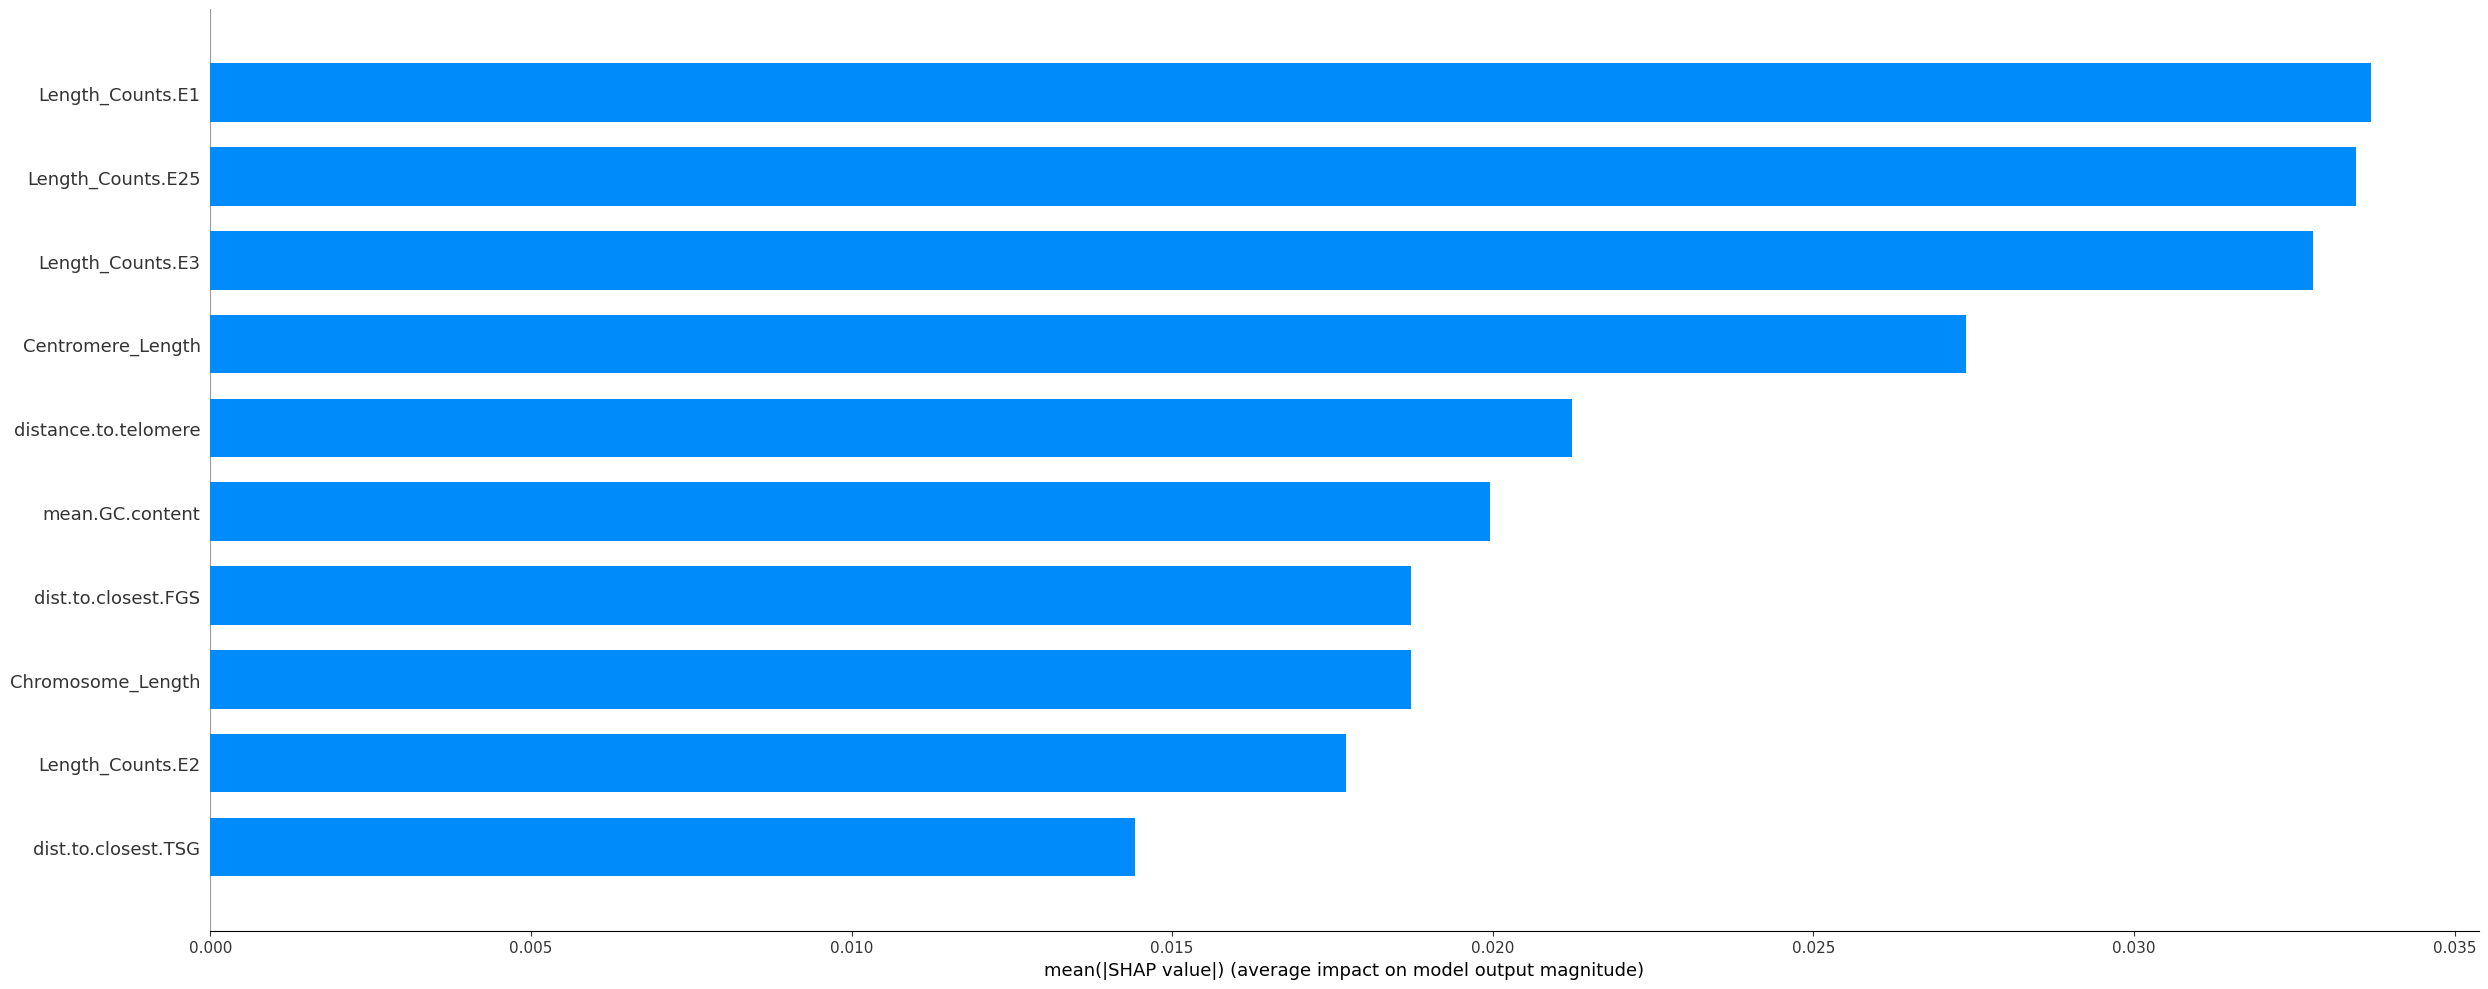

In [67]:
if plot_shap:
    print(" / ".join([mode, condition]))
    plt.figure(figsize = (100,25))
    summary_plot = shap.summary_plot(shap_values, X_train, 
                                     plot_type='bar', max_display=10, plot_size= (25,10), rng = 42)
    plt.show()

## Feature Selection

Let's perform Feature Selection using mean absolute SHAP values

> threshold=0.0, features=51, adj_R2=0.46289794318793603
> threshold=0.0, features=51, adj_R2=0.46289794318793603
> threshold=0.000688491330947727, features=49, adj_R2=0.45405269725188185
> threshold=0.0007393810665234923, features=48, adj_R2=0.45077497253384724
> threshold=0.0009075828711502254, features=47, adj_R2=0.4530172068529578
> threshold=0.0011593110393732786, features=46, adj_R2=0.4526639963542678
> threshold=0.0016865090001374483, features=45, adj_R2=0.45363933708029486
> threshold=0.002149035921320319, features=44, adj_R2=0.45737401948819895
> threshold=0.0026378075126558542, features=43, adj_R2=0.4454619025587767
> threshold=0.002687104046344757, features=42, adj_R2=0.4579079569543534
> threshold=0.002741059986874461, features=41, adj_R2=0.4656327903308773
> threshold=0.0029773947317153215, features=40, adj_R2=0.4562414043906178
> threshold=0.003232568269595504, features=39, adj_R2=0.45498163534513153
> threshold=0.0037573818117380142, features=38, adj_R2=0.451352198876302

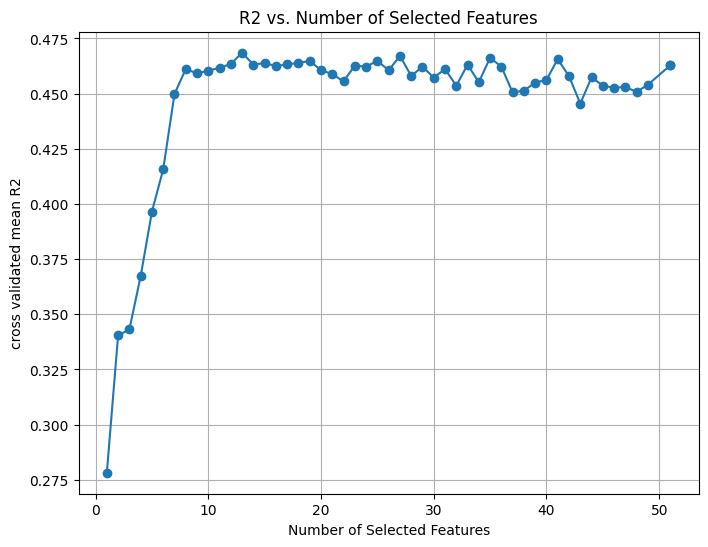

Optimal Threshold: 0.0085
Number of Selected Features: 13
R2 at Optimal Threshold: 0.4685


Selected features are: 

mean.GC.content  total_n_PPIs.trans_IntINSIDER  dist.to.closest.FGS  Length_Counts.E1  Length_Counts.E2
Length_Counts.E25  Length_Counts.E3  Length_Counts.E7  dist.to.closest.TSG  distance.to.centromere
distance.to.telomere  Chromosome_Length  Centromere_Length


Discarded features are: 

ampl_score  del_score  total_n_partners.trans  total_n_ohnologs.mmpaper_trans  total_n_paralogs_trans
Length_Counts.E10  Length_Counts.E11  Length_Counts.E12  Length_Counts.E13  Length_Counts.E14
Length_Counts.E15  Length_Counts.E16  Length_Counts.E17  Length_Counts.E18  Length_Counts.E19
Length_Counts.E20  Length_Counts.E21  Length_Counts.E22  Length_Counts.E23  Length_Counts.E24
Length_Counts.E4  Length_Counts.E5  Length_Counts.E6  Length_Counts.E8  Length_Counts.E9
all.int.trans_IntINSIDER  genes.bin  partners.trans  density.OG  density.TSG
dist.to.closest.OG  mutations_norm  Ess.dis

In [68]:
feature_names = model.feature_names_in_
feature_importances_shap = np.mean(np.abs(explainer.shap_values(X_train)), axis = 0)

X_train_reduced, X_test_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                            model, X_train, X_test, y_train, 
                                                                            inner_cv = inner_cv,
                                                                            plot = True, verbose = True)

In [69]:
features_to_discard = [feature for feature in selected_features if feature not in selected_features_in_at_least_one_cv]

In [70]:
print(f"Dropping columns never selected during Nested Cross Validation: {features_to_discard}")

Dropping columns never selected during Nested Cross Validation: []


In [71]:
X_train_reduced = X_train_reduced.drop(features_to_discard, axis = 1); X_test_reduced = X_test_reduced.drop(features_to_discard, axis = 1)

In [72]:
final_set_of_features = X_train_reduced.columns

In [73]:
opti_fs = sk.model_selection.RandomizedSearchCV(estimator = model, 
                                                param_distributions = search_space_grid, 
                                                cv = inner_cv, 
                                                n_jobs = n_jobs,
                                                n_iter = n_iter_rsearch,
                                                random_state = hypertune_random_state_rsearch, 
                                                verbose = 0, refit = True)
opti_fs.fit(X_train_reduced, y_train)
clear_output(wait = False)

In [74]:
model_fs = opti_fs.best_estimator_

In [75]:
best_params_fs = opti_fs.best_params_

for k,v in best_params_fs.items():
    print(f"{k}: {v}")

subsample: 1.0
scale_pos_weight: 0.0002314598750905375
reg_lambda: 203.3571339254888
reg_alpha: 0.00042005638435181457
n_estimators: 100
min_child_weight: 6
max_depth: 7
max_delta_step: 18
learning_rate: 0.1578839395023948
gamma: 3.1680382752899045e-09
colsample_bytree: 0.9156911123827687
colsample_bylevel: 0.5376587596385864


In [76]:
mean_r2_cv = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = "r2"))
mean_rmse_cv = np.mean(-sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = "neg_root_mean_squared_error"))

In [77]:
print(f"Cross Validated r2 (cv = {outer_cv}) is: {mean_r2_cv}")
print(f"Cross Validated rmse (cv = {outer_cv}) is: {mean_rmse_cv}")

Cross Validated r2 (cv = 5) is: 0.4972086857240858
Cross Validated rmse (cv = 5) is: 0.22746321114418291


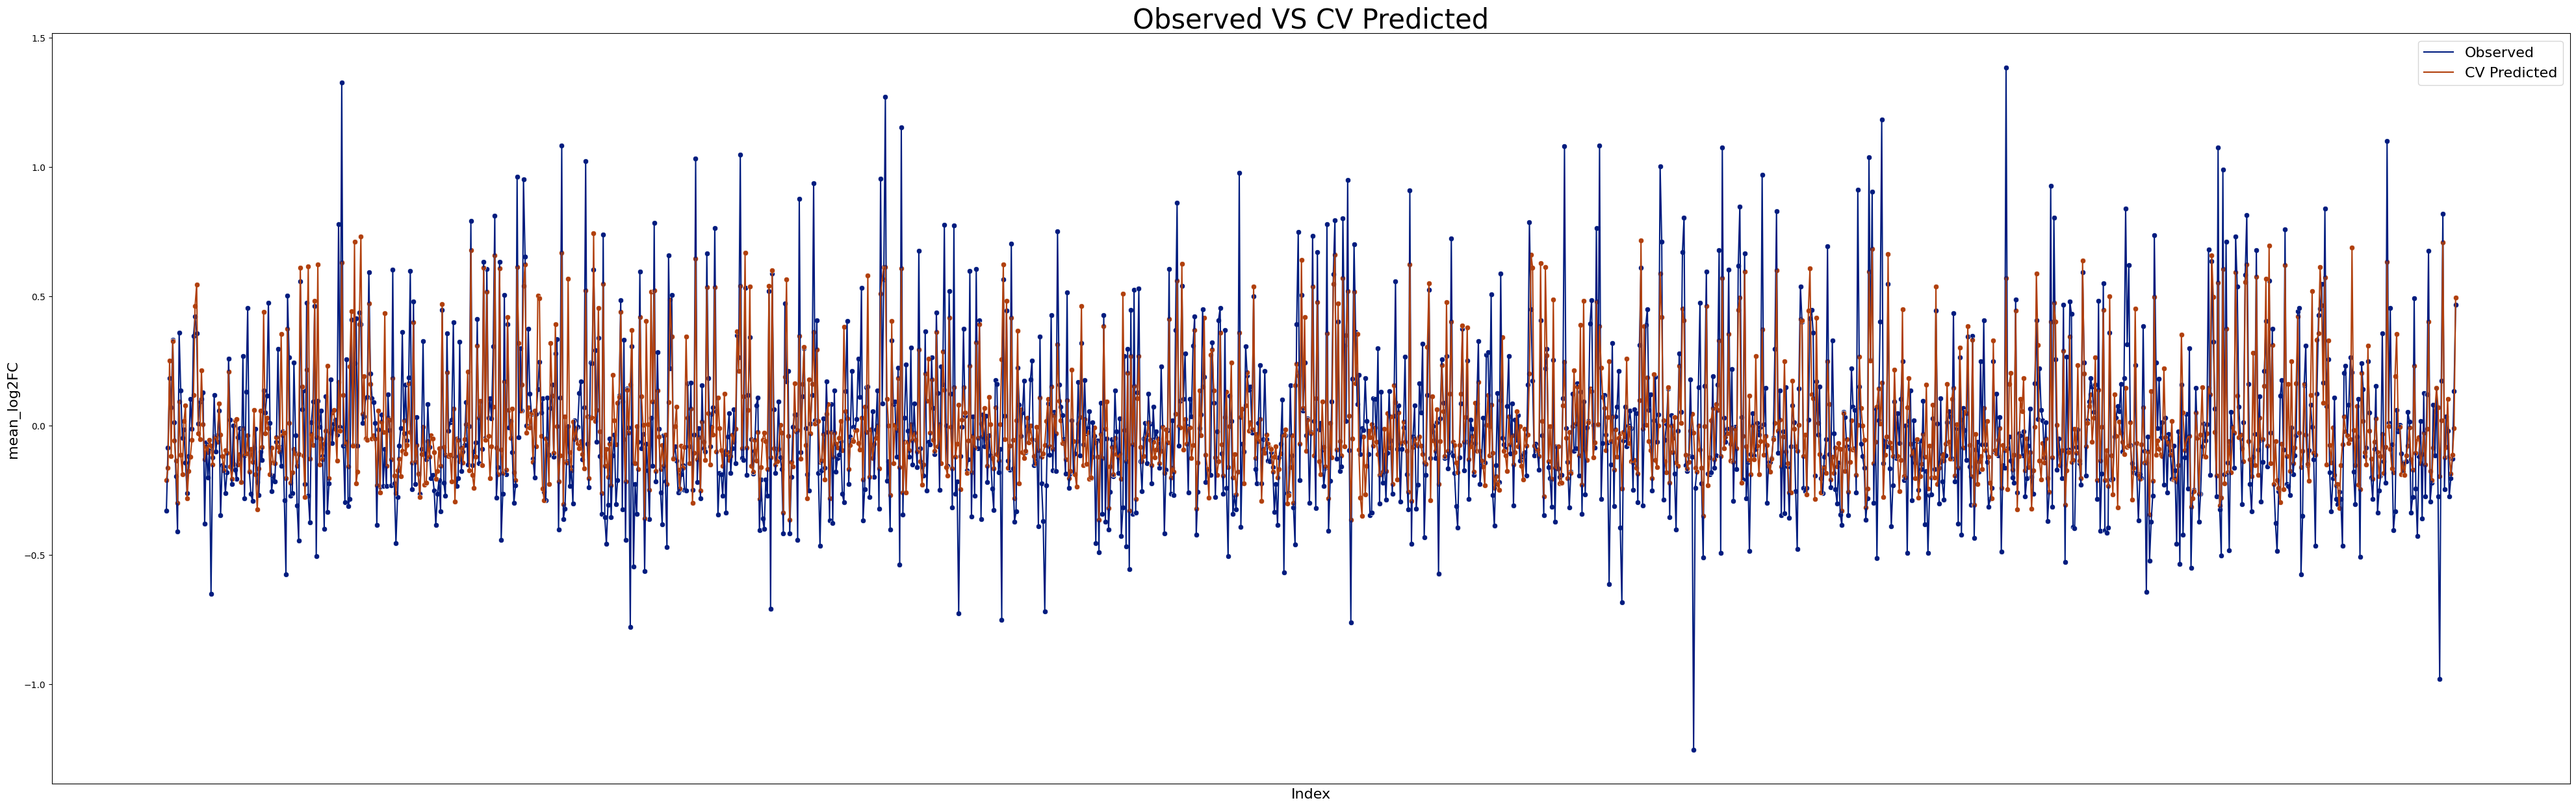

In [78]:
if plot_variation:
    plt.figure(figsize = (50,15))
    plot_observed_predicted([y_train, sk.model_selection.cross_val_predict(model_fs, X_train_reduced, y_train, cv = outer_cv, method = "predict")],
                            ["Observed","CV Predicted"], 
                            title = "Observed VS CV Predicted", 
                            x_label = "Index", y_label = "mean_log2FC")

## Store Variables for later

In [79]:
pickle.dump(X_train_reduced,open(X_train_filename,"wb"))
pickle.dump(X_test_reduced,open(X_test_filename,"wb"))
pickle.dump(y_train,open(y_train_filename,"wb"))
pickle.dump(y_test,open(y_test_filename,"wb"))
pickle.dump(bin_train,open(bin_train_filename,"wb"))
pickle.dump(bin_test,open(bin_test_filename,"wb"))
pickle.dump(model_fs,open(model_filename,"wb"))